In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

# Hide Warnings
pd.options.mode.chained_assignment = None

# Intelligent Data Analysis Project: Income

A polling institute wants to be able to estimate an individual’s income from his/her personal data (see einkommen.train). To this aim, 30.000 individuals were interviewed concerning the features summarized below. For some of the individuals, not all features are available. Crucially, the income of only 5.000 of the interviewee’s is known.

Your task is to predict the income group of the remaining 25.000 interviewees and to prepare the data such that they can be used for further regression and correlation analyses.

Load the data into Python and preprocess it. Choose adequate data transformations, normalizations etc. and decide on how to deal with missing values (marked with “?”). Consider which kinds of features the preprocessed data shall contain. Once you have preprocessed the data, train a model to predict a person’s income group and apply it to the 25.000 individuals whose income group is unknown. Identify a suitable learning method and implement it in Python. Train and evaluate the model. Provide a short documentation and motivation of each of your steps.

In [2]:
# Import data set and add column names
income = pd.read_csv('data/einkommen.train', sep=",", na_values = " ?", header=None)

# Set Column Names
columns = ["Age", "Employment Type", "Weighting Factor", "Education Level", "Schooling/Training Period", "Marital Status", "Employment Area", "Partnership", "Ethnicity", "Gender", "Gains", "Losses", "Weekly Working Time", "Country Of Birth", "Income"]
income.columns = columns

# Remove leading/trailing whitespaces from columns that contain strings
string_columms = income.select_dtypes(object).columns
income[string_columms] = income[string_columms].apply(lambda x: x.str.strip())

In [3]:
# Split data set into sets where Income is known or unknwn
income_labeled = income[income['Income'].notnull()]
income_unlabeled = income[income['Income'].isnull()]

In [4]:
income_labeled.nunique()

Age                            69
Employment Type                 7
Weighting Factor             4603
Education Level                16
Schooling/Training Period      16
Marital Status                  7
Employment Area                14
Partnership                     6
Ethnicity                       5
Gender                          2
Gains                          83
Losses                         55
Weekly Working Time            74
Country Of Birth               39
Income                          2
dtype: int64

In [5]:
income_labeled.isna().sum()

Age                            0
Employment Type              331
Weighting Factor               0
Education Level                0
Schooling/Training Period      0
Marital Status                 0
Employment Area              331
Partnership                    0
Ethnicity                      0
Gender                         0
Gains                          0
Losses                         0
Weekly Working Time            0
Country Of Birth              97
Income                         0
dtype: int64

In [6]:
# income_labeled[income_labeled['Employment area'].isnull()].sort_values(by="Working time(Weekly)")
# income_labeled['Country'].unique()

## Problem Setting

## Analysis

In [7]:
# Look at input values
income_labeled.head()

,Age,Employment Type,Weighting Factor,Education Level,Schooling/Training Period,Marital Status,Employment Area,Partnership,Ethnicity,Gender,Gains,Losses,Weekly Working Time,Country Of Birth,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
income_labeled.describe()

,Age,Weighting Factor,Schooling/Training Period,Gains,Losses,Weekly Working Time
count,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000
mean,38.600200,1.907684e+05,10.079600,1033.640200,93.696800,40.519000
std,13.594695,1.063596e+05,2.534906,7051.802077,410.801418,12.109193
min,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176958e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.794750e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.416575e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.033222e+06,16.000000,99999.000000,2547.000000,99.000000


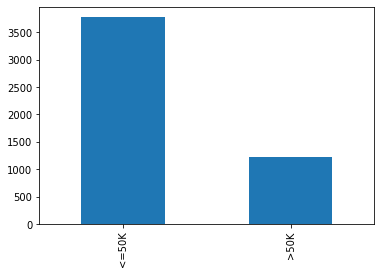

In [9]:
# Check balance between label that has to be predicted
target_distribution = income_labeled['Income'].value_counts().plot(kind='bar')

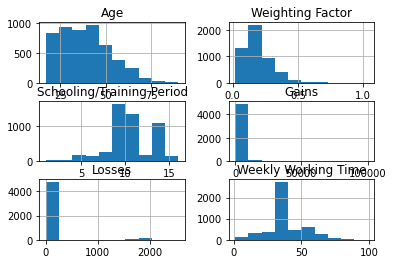

In [10]:
# Check how numeric values are distributed
numeric_distribution = income_labeled.hist()

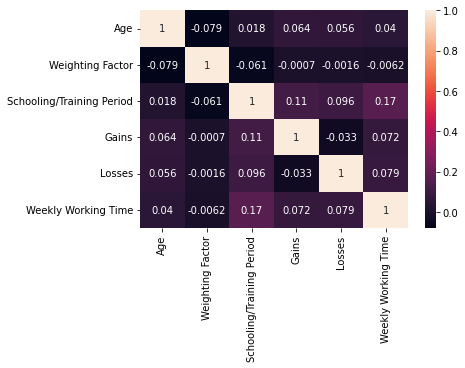

In [11]:
# Correlations between numeric features
correlation_matrix = sns.heatmap(income_labeled.corr(), annot=True)

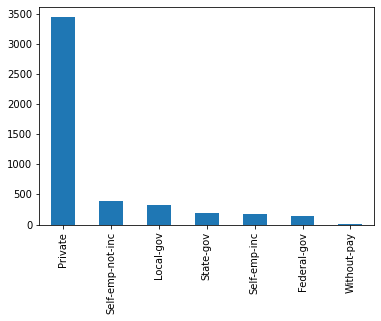

In [12]:
employment_type_distribution = income_labeled['Employment Type'].value_counts().plot(kind='bar')

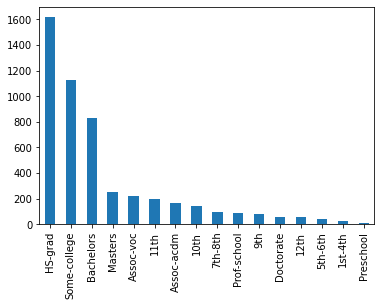

In [13]:
education_distribution = income_labeled['Education Level'].value_counts().plot(kind='bar')

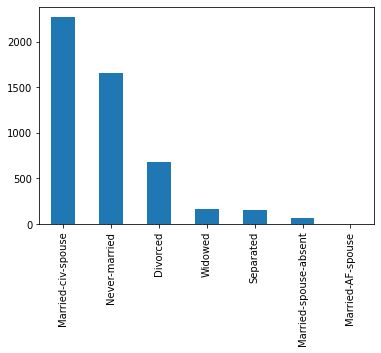

In [14]:
maritial_status_distribution = income_labeled['Marital Status'].value_counts().plot(kind='bar')

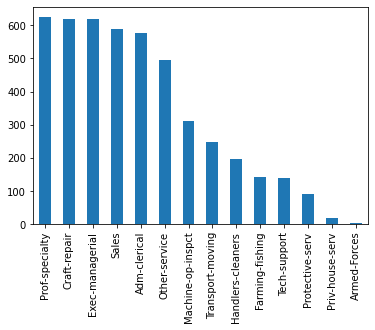

In [15]:
employment_area_distribution = income_labeled['Employment Area'].value_counts().plot(kind='bar')

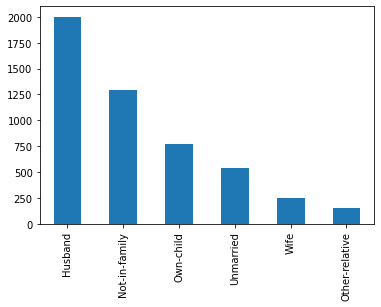

In [16]:
partnership_distributon = income_labeled['Partnership'].value_counts().plot(kind='bar')

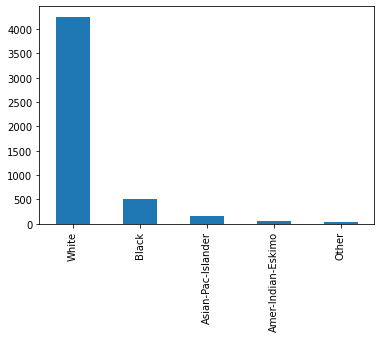

In [17]:
ethnicity_distribution = income_labeled['Ethnicity'].value_counts().plot(kind='bar')

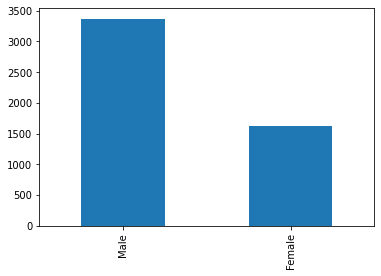

In [18]:
gender_distribution = income_labeled['Gender'].value_counts().plot(kind='bar')

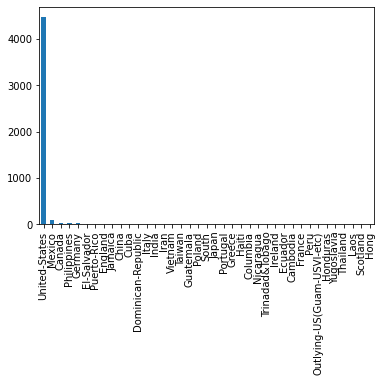

In [19]:
country_distribution = income_labeled['Country Of Birth'].value_counts().plot(kind='bar')

## Data Preparation

In [20]:
# Remove irrelevant/unused column
income_labeled = income_labeled.drop('Weighting Factor', axis=1)

In [21]:
## Handling Missing Values
print(income_labeled.isna().sum())

income_labeled = income_labeled.dropna()

Age                            0
Employment Type              331
Education Level                0
Schooling/Training Period      0
Marital Status                 0
Employment Area              331
Partnership                    0
Ethnicity                      0
Gender                         0
Gains                          0
Losses                         0
Weekly Working Time            0
Country Of Birth              97
Income                         0
dtype: int64


In [22]:
from sklearn.preprocessing import OrdinalEncoder

# Ordinal Encoding for Education Level (ordinal)
education_level = ['Preschool','1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', 'Some-college', 'Bachelors', 'Masters', 'Doctorate']
oe_edu = OrdinalEncoder(categories=[education_level])

income_labeled['Education Level'] = income_labeled['Education Level'].str.strip()
income_labeled['Education Level'] = oe_edu.fit_transform(income_labeled[['Education Level']])

In [23]:
# One-Hot Encoding for categorical variables (without order)
one_hot_columns = ['Employment Type', 'Marital Status', 'Employment Area', 'Partnership', 'Ethnicity', 'Gender', 'Country Of Birth']
income_labeled = pd.get_dummies(income_labeled, columns=one_hot_columns)


In [24]:
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encode categorical variables
income_labeled['Income'].replace(['<=50K', '>50K'], [0, 1], inplace=True)

In [25]:
# Standardization / Z-Score Normalization

In [26]:
from sklearn.model_selection import train_test_split

# Train / Test-Split
income_X_train, income_X_test, income_y_train, income_y_test = train_test_split(income_labeled.drop('Income', axis=1), income_labeled['Income'], test_size=0.25, random_state=42)

## Methods (& Experiments)

### Linear Classification

In [27]:
from sklearn import svm
from sklearn.metrics import accuracy_score

clf = svm.SVC(random_state=42)
clf.fit(income_X_train, income_y_train)

income_y_pred = clf.predict(income_X_test)

accuracy_score(income_y_test, income_y_pred)

0.8096069868995633

### Decision Trees

0.7868995633187773

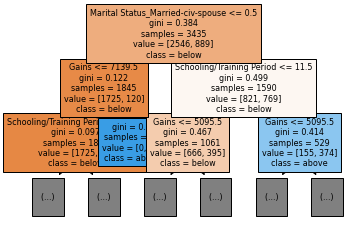

In [28]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(income_X_train, income_y_train)
tree.plot_tree(clf, max_depth=2, fontsize=8, feature_names=income_X_train.columns, filled=True, class_names=["below", "above"])

income_y_pred = clf.predict(income_X_test)

accuracy_score(income_y_test, income_y_pred)

## Conclusion